2020136098 이선우 HW2

# **titanic_dataset.py**

In [39]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split


class TitanicDataset(Dataset):
  def __init__(self, X, y): #X는 특징, Y는 타겟
    self.X = torch.FloatTensor(X) # 입력 데이터를 float tensor로
    self.y = torch.LongTensor(y)  # 타겟 데이터를 long tensor로

  def __len__(self): # 데이터셋 길이 반환
    return len(self.X)

  def __getitem__(self, idx): # 해당 인덱스 특징, 타겟 반환
    feature = self.X[idx]
    target = self.y[idx]
    return {'input': feature, 'target': target}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str

Titanic 데이터셋을 관리한다. 
특징(feature)와 타겟(target) 값을 저장하고 데이터 셋의 길이 확인, 인덱스로 특징, 타겟 값을 반환하며 데이터셋의 크기와 형태를 확인할 수 있다.



In [40]:
class TitanicTestDataset(Dataset):
  def __init__(self, X): # float tensor로 변환
    self.X = torch.FloatTensor(X)

  def __len__(self): # 데이터셋 길이 반환
    return len(self.X)

  def __getitem__(self, idx): # 해당 입력 데이터 반환
    feature = self.X[idx]
    return {'input': feature}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}".format(
      len(self.X), self.X.shape
    )
    return str

Titanic Test 데이터셋을 관리한다. 검증 데이터셋이므로 특징만 FloatTensor로 변환해 저장하며 데이터 셋의 길이 확인, 인덱스로 특징 값을 반환하며 데이터셋의 크기와 형태를 확인할 수 있다. 

In [41]:
def get_preprocessed_dataset():
    #팡일 경로 설정
    CURRENT_FILE_PATH = os.getcwd()
    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    # csv 파일 불러오고 저장
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    # 훈련, 테스트 데이터 결합 후 전처리 함수 적용
    all_df = pd.concat([train_df, test_df], sort=False)
    all_df = get_preprocessed_dataset_1(all_df)
    all_df = get_preprocessed_dataset_2(all_df)
    all_df = get_preprocessed_dataset_3(all_df)
    all_df = get_preprocessed_dataset_4(all_df)
    all_df = get_preprocessed_dataset_5(all_df)
    all_df = get_preprocessed_dataset_6(all_df)

    # 위 과정 거친 후 데이터셋을 훈련, 검증용으로 분할
    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]
    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)


    dataset = TitanicDataset(train_X.values, train_y.values)
    #print(dataset)
    # 데이터셋 전체를 비율에 따라 분할, 훈련 - 80%, 검증 - 20%
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    # 데스트 데이터셋 생성, 타깃 없음
    test_dataset = TitanicTestDataset(test_X.values)
    #print(test_dataset)

    return train_dataset, validation_dataset, test_dataset

데이터 전처리 후 학습, 검증, 테스트 데이터셋을 반환하는 함수이다. train.csv, test.csv 파일을 불러온 후 하나의 데이터프레임으로 합친다. 합친 데이터를 get_preprocessed_dataset_1 ... get_preprocessed_dataset_6의 전처리 과정을 거치고 훈련 / 검증 데이터로 분할한다. <br><br>
train_X => 결측치가 없는 샘플들 중에서 생존 여부 정보를 제외한 훈련용 특징 데이터<br>
train_y => 타깃(target) 훈련 데이터의 생존 여부 데이터
test_X => 테스트 데이터의 특징 데이터<br><br>
데이터셋 전체를 비율에 따라 분할하며 train_dataset - 80%, validation_dataset - 20% 테스트 데이터셋을 생성한다.

In [42]:
def get_preprocessed_dataset_1(all_df): # 전처리 함수 - Fare 결측치 처리
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]

    return all_df

Fare 결측치를 처리한다. Pclass별로 승객의 Fare 평균 계산한 후 Fare값이 결측치이면 Pclass에 따른 평균 Fare로 값을 채운다

In [43]:
def get_preprocessed_dataset_2(all_df): # 전처리 함수 - Name 분리(family_name, honorific, name)
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "honorific", "name"]
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["honorific"] = name_df["honorific"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    # 원본 데이터프레임에 추가
    all_df = pd.concat([all_df, name_df], axis=1)

    return all_df

Name을 분리한다. 이름 컬럼을 ,. 기준으로 family_name, honorific, name로 문자열을 나누고 공백을 제거한다.

In [44]:
def get_preprocessed_dataset_3(all_df): # 전처리 함수 - Age 결측치 처리
    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ]
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    # honorific_age_mean 컬럼 제거
    all_df = all_df.drop(["honorific_age_mean"], axis=1)

    return all_df

Age 결측치를 처리한다. honorific별로 Age의 평균값을 구해 결측치가 있는 Age 값을 채운다. 

In [45]:
def get_preprocessed_dataset_4(all_df): # 전처리 함수 - 가족 수 계산 및 불필요한 컬럼 삭제
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"].fillna(0, inplace=True)

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df

가족 수 계산 및 불필요한 컬럼을 제거한다. Parch와 SibSp을 더해 가족 수를 계한하는 컬럼을 추가하고 가족 수가 0인 승객은 alone 컬럼을 추가하며 결측치도 처리한다. 학습에 이용되지 않는 컬럼은 제거한다.

In [46]:
def get_preprocessed_dataset_5(all_df): # 전처리 함수 - honorific 값 단순화
    # honorific 값 개수 줄이기
    all_df.loc[
    ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
    ),
    "honorific"
    ] = "other"
    # Embarked 결측치를 "missing"으로 채움
    all_df["Embarked"].fillna("missing", inplace=True)

    return all_df


honorific 값을 단순화한다. honorific 값이 Mr, Miss, Mrs, Master에 속하지 않는 승객들의 honorific 값을 other로 합친다. Embarked 컬럼의 결측치는 missing으로 채운다.

In [47]:
def get_preprocessed_dataset_6(all_df): # 전처리 함수 - 카테고리형 변수 수치형로 변환
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    category_features = all_df.columns[all_df.dtypes == "object"]
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features:
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
          le = le.fit(all_df[category_feature])
          all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df

카테고리형 변수를 수치값으로 변경한다. object 타입인 칼럼을 ategory_features에 담아 LabelEncoder를 이용하여 수치값으로 변경한다. ex) "C", "Q", "S" -> 0, 1, 2

In [48]:
from torch import nn
class MyModel(nn.Module):
  def __init__(self, n_input, n_output):
    super().__init__()
    # ReLU 사용
    self.model = nn.Sequential(
      nn.Linear(n_input, 30),
      nn.ReLU(),
      nn.Linear(30, 30),
      nn.ReLU(),
      nn.Linear(30, n_output),
    )

  def forward(self, x):
    x = self.model(x)
    return x

클래스 MyModel => PyTorch의 nn.Module 클래스 상속받은 클래스<br>
첫 번째 Fully Connected Layer => 특성 수만큼의 데이터를 받아 30개의 출력값을 생성<br>
활성화 함수 ReLU 이용 입력이 0보다 크면 그대로 반환하고, 0 이하인 경우 0을 반환<br>
두 번째 Fully Connected Layer => 30개의 입력을 받아 30개의 출력값을 생성<br>
다시 ReLU를 사용하여 비선형성 추가<br>
마지막 출력층 =>  30개의 입력을 받아 출력 차원(n_output)만큼의 값을 생성 (생존할 확률과 사망할 확률 각각 출력)

순전파 함수 forward

In [49]:
# 테스트 함수
def test(test_data_loader):
  print("[TEST]")
  # test_data_loader에서 첫 번째 배치 가져옴
  batch = next(iter(test_data_loader))
  print("{0}".format(batch['input'].shape))
  # 모델 객체 생성 (11개 특징 입력, 출력 차원은 2 / 생존여부(0,1))
  my_model = MyModel(n_input=11, n_output=2)
  # 배치의 입력 데이터 받고 예측 수행
  output_batch = my_model(batch['input'])
  # 높은 값 반환
  prediction_batch = torch.argmax(output_batch, dim=1)
  for idx, prediction in enumerate(prediction_batch, start=892):
      print(idx, prediction.item())

테스트 데이터를 이용하여 모델이 예측한 결과 출력<br>
test_data_loader에서 첫 번째 배치 가져오고 모델 객체 생성 (11개 특징 입력, 출력 차원은 2 / 생존여부(0,1))<br>
batch['input'] 데이터를 모델에 입력하여 예측,  각 승객에 대해 두 개의 출력 값을 반환 ex) [0.2, 0.8] => 생존할 확률이 80% 사망할 확률이 20%<br>
예측 결과 중 가장 높은 값을 가지는 인덱스를 반환

In [53]:
if __name__ == "__main__":
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

  print("train_dataset: {0}, validation_dataset.shape: {1}, test_dataset: {2}".format(
    len(train_dataset), len(validation_dataset), len(test_dataset)
  ))
  print("#" * 50, 1)

  for idx, sample in enumerate(train_dataset):
    print("{0} - {1}: {2}".format(idx, sample['input'], sample['target']))

  print("#" * 50, 2)

  # 데이터 로더 설정
  train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=True)
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

  print("[TRAIN]")
  for idx, batch in enumerate(train_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("[VALIDATION]")
  for idx, batch in enumerate(validation_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("#" * 50, 3)

    #테스트
  test(test_data_loader)

C:\Users\이선우\AppData\Local\Temp\ipykernel_10876\4144865856.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
C:\Users\이선우\AppData\Local\Temp\ipykernel_10876\4050156303.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

train_dataset: 713, validation_dataset.shape: 178, test_dataset: 418
################################################## 1
0 - tensor([ 1.0000,  0.0000, 52.0000,  1.0000,  1.0000, 93.5000,  2.0000, 87.5090,
         3.0000,  2.0000,  0.0000]): 1
1 - tensor([ 3.0000,  0.0000, 21.0000,  0.0000,  0.0000,  7.6500,  2.0000, 13.3029,
         1.0000,  0.0000,  1.0000]): 1
2 - tensor([ 1.0000,  0.0000, 22.0000,  1.0000,  0.0000, 66.6000,  2.0000, 87.5090,
         3.0000,  1.0000,  0.0000]): 1
3 - tensor([ 3.0000,  0.0000, 22.0000,  1.0000,  0.0000, 24.1500,  1.0000, 13.3029,
         1.0000,  1.0000,  0.0000]): 1
4 - tensor([ 3.0000,  0.0000, 26.0000,  0.0000,  0.0000,  7.9250,  2.0000, 13.3029,
         1.0000,  0.0000,  1.0000]): 1
5 - tensor([ 3.0000,  0.0000, 15.0000,  1.0000,  0.0000, 14.4542,  0.0000, 13.3029,
         3.0000,  1.0000,  0.0000]): 1
6 - tensor([ 3.0000,  1.0000, 29.0000,  0.0000,  0.0000,  7.2250,  0.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
7 - tensor([ 3.00

데이터셋 로드하고 전처리<br>
각 데이터셋의 크기 및 내용을 확인<br>
데이터 로더를 설정하여 데이터를 배치 단위로 처리<br>
훈련 및 검증 데이터 로더에서 배치의 내용을 출력<br>
테스트를 수행<br>
출력을 확인해보면 테스트 데이터에 대한 예측된 생존 여부가 나타난것을 볼 수 있다.

# **my_model_training.py**

In [77]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import wandb
import argparse
import pandas as pd
from pathlib import Path

BASE_PATH = str(Path.cwd().parent.parent)  # 현재 작업 디렉터리에서 상위 2단계로 이동
print(BASE_PATH, "!!!!!!!")

import sys
sys.path.append(BASE_PATH)  

# Titanic 데이터셋 불러오기 및 전처리 함수
from titanic_dataset import get_preprocessed_dataset

C:\Users\이선우\git\link_dl !!!!!!!


In [78]:
def get_data():
    # 데이터셋 불러오기, 전처리
    train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

    print(len(train_dataset), len(validation_dataset))

    # 데이터 로더 생성
    train_data_loader = DataLoader(dataset=train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset))

    return train_data_loader, validation_data_loader, test_dataset

In [79]:
class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()

        # 타이타닉 데이터에 입출력 (11개 입력, 2개 출력 (생존/사망))
        self.model = nn.Sequential(
            nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
            nn.ReLU(),
            nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
            nn.ReLU(),
            nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
        )

    def forward(self, x):
        x = self.model(x)
        return x

활성화 함수로 **ReLU** 사용 <br>해보니 제일 잘나옴

ReLU : 입력이 양수일 때는 그대로 출력, 음수일 때는 0을 출력하는 활성화 함수, 음수에서 기울기가 0이 되어 죽은 뉴런 문제를 일으킬 수 있음.
<br>ELU : 음수에서는 지수 함수로 변환하고, 양수에서는 그대로 출력하는 활성화 함수, 음수에서도 작은 값으로 변화시켜, 죽은 뉴런 문제를 완화 가능
<br>Leaky ReLU : ReLU와 유사하지만, 음수 입력에 대해 작은 기울기를 허용하는 활성화 함수. 음수에서도 작은 기울기가 있어 죽은 뉴런 문제를 해결가능
<br>PReLU : Leaky ReLU와 유사하지만, 음수 입력에 대한 기울기 α 값을 학습할 수 있는 활성화 함수.

활성화 함수?? 비선형성을 도입

In [80]:
def get_model_and_optimizer():
    # 타이타닉 데이터셋 입력은 11개, 출력 2개 (생존 여부)
    my_model = MyModel(n_input=11, n_output=2)
    optimizer = optim.SGD(my_model.parameters(), lr=wandb.config.learning_rate)

    return my_model, optimizer

모델을 생성하며 최적화 알고리즘을 설정한다. (SGD(Stochastic Gradient Descent) 알고리즘 => 경사하강법을 통해 모델의 파라미터를 업데이트) <br>
학습률(learning rate)을 wandb 설정에서 가져옴

In [92]:
def training_loop(model, optimizer, train_data_loader, validation_data_loader):
    n_epochs = wandb.config.epochs # 학습할 에포크 수를 wandb 설정에서 가져옴
    loss_fn = nn.CrossEntropyLoss()  # 이진 분류 문제를 위한 손실 함수
    next_print_epoch = 100 # # 학습 정보를 출력 주기 100 에포크
    patience = 20  # Early stopping 기준 patience 값
    best_validation_loss = float('inf') # validation_loss 최소값 저장
    early_stop_counter = 0 # validation_loss 개선되지 않은 에포크 횟수

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        num_trains = 0
        for train_batch in train_data_loader:
            input = train_batch['input']
            target = train_batch['target']
            output_train = model(input)
            loss = loss_fn(output_train, target) # 예측 값과 실제 값 사이의 손실을 계산
            loss_train += loss.item()
            num_trains += 1

            optimizer.zero_grad() # 이전 배치에서 계산된 기울기를 초기화
            loss.backward() # 현재 배치에 대한 손실 값을 기준으로 기울기를 계산
            optimizer.step() # 기울기를 사용해 모델의 파라미터를 업데이트

        loss_validation = 0.0
        num_validations = 0
        with torch.no_grad(): #  검증 단계에서는 기울기 계산 X
            for validation_batch in validation_data_loader: # 검증 데이터 불러옴
                input = validation_batch['input']
                target = validation_batch['target']
                output_validation = model(input) #예측 값 계산
                loss = loss_fn(output_validation, target) # 예측 값과 실제 답 사이 차이 계산
                loss_validation += loss.item() #
                num_validations += 1 # 배치 수

        avg_validation_loss = loss_validation / num_validations


        wandb.log({
            "Epoch": epoch,
            "Training loss": loss_train / num_trains,
            "Validation loss": avg_validation_loss
        })

        if epoch >= next_print_epoch: # 에포크 결과 출력
            print(
                f"Epoch {epoch}, "
                f"Training loss {loss_train / num_trains:.4f}, "
                f"Validation loss {avg_validation_loss:.4f}"
            )
            next_print_epoch += 100

            # 100 에포크마다 Early stopping 체크
            if avg_validation_loss < best_validation_loss:
                best_validation_loss = avg_validation_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= patience: # validation_loss가 patience 에포크 동안 개선되지 않으면 학습 중단
                print(f"{early_stop_counter}동안 epochs 개선 x.")
                print(f"Early stopping at epoch {epoch}")
                break

손실 함수로 CrossEntropyLoss() 사용
<br>**CrossEntropyLoss()** : 분류 문제를 다룰 때 사용되는 손실 함수 <br>모델이 예측한 클래스 확률과 실제 정답 레이블 간의 차이를 측정하는 손실 함수이며 이진 분류 문제에서 모델이 잘못된 예측을 했을 때 큰 손실 값을 반환함.

훈련과정 중 어느 Epoch 시점에 테스트를 수행하여 submission.csv를 구성할 지 알기 위해 Early stopping 사용 <br>
**Early stopping** : 모델 학습 과정에서 검증 성능이 더 이상 개선되지 않을 때 학습을 중단함 <br>
에포크마다 검증 데이터에 대한 Validation Loss을 계산하고 검증 손실이 더 이상 감소하지 않고 일정 횟수 동안 개선되지 않으면 학습을 중단한다.


In [93]:
def save_submission_file(model, test_dataset, output_file="submission.csv"):
    # test 데이터 로더 생성
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

    # 예측 수행
    predictions = []
    with torch.no_grad(): # 예측엔 기울기 계싼 x
        for batch in test_data_loader: # 테스트 데이터셋에서 입력 데이터를 가져옴
            input_data = batch['input']
            output = model(input_data) # 모델에 입력 데이터를 전달해 예측 값 가져옴
            predicted_labels = torch.argmax(output, dim=1) # 모델이 출력한 값에서 가장 큰 값을 가진 클래스를 선택
            predictions.extend(predicted_labels.cpu().numpy())  # 예측 결과를 리스트에 저장


    passenger_ids = list(range(892, 892 + len(test_dataset)))  # 테스트 데이터셋 PassengerId는 892부터 시작
    submission_df = pd.DataFrame({
        "PassengerId": passenger_ids,
        "Survived": predictions
    })
    submission_df.to_csv(output_file, index=False)
    print(f"Submission file saved to {output_file}")

예측을 수행하고 예측 결과에 대한 csv 파일을 저장한다.

In [94]:
def main(args):
    current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'learning_rate': 1e-3,
        'n_hidden_unit_list': [20, 20],
    }

    wandb.init(
        mode="online" if args.wandb else "disabled",
        project="titanic_model_training",
        notes="Titanic dataset experiment",
        tags=["titanic", "classification"],
        name=current_time_str,
        config=config
    )
    print(args)
    print(wandb.config)

    train_data_loader, validation_data_loader, test_dataset = get_data()

    linear_model, optimizer = get_model_and_optimizer() # 모델 및 최적화 함수 생성

    print("#" * 50, 1)

    training_loop(
        model=linear_model,
        optimizer=optimizer,
        train_data_loader=train_data_loader,
        validation_data_loader=validation_data_loader
    )

    # 테스트 데이터셋을 사용하여 결과를 저장
    save_submission_file(model=linear_model, test_dataset=test_dataset, output_file="submission.csv")

    wandb.finish()

모델 설정과 함께 Wandb를 통해 기록<br>
Titanic 데이터셋을 훈련, 검증, 테스트용으로 나누어 로드<br>
훈련 루프를 통해 모델을 학습<br>
테스트 데이터를 사하여 예측 수행, submission.csv 파일 저장<br>
Wandb 업로드

In [95]:
# https://docs.wandb.ai/guides/track/config
if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Wandb 설정
    parser.add_argument(
        "--wandb", action=argparse.BooleanOptionalAction, default=True, help="True or False"
    )

    # 배치 크기 설정
    parser.add_argument(
        "-b", "--batch_size", type=int, default=512, help="Batch size (int, default: 512)"
    )

    # 에포크 수 설정
    parser.add_argument(
        "-e", "--epochs", type=int, default=5_0000, help="Number of training epochs (int, default: 50000)"
    )

    args, unknown = parser.parse_known_args()

    # main 함수 실행
    main(args)

Namespace(wandb=True, batch_size=512, epochs=50000)
{'epochs': 50000, 'batch_size': 512, 'learning_rate': 0.001, 'n_hidden_unit_list': [20, 20]}


C:\Users\이선우\git\link_dl\_02_homeworks\homework_2\titanic_dataset.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
C:\Users\이선우\git\link_dl\_02_homeworks\homework_2\titanic_dataset.py:140: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

713 178
################################################## 1
Epoch 100, Training loss 0.5854, Validation loss 0.6714
Epoch 200, Training loss 0.5896, Validation loss 0.6669
Epoch 300, Training loss 0.5605, Validation loss 0.6640
Epoch 400, Training loss 0.5734, Validation loss 0.6612
Epoch 500, Training loss 0.5534, Validation loss 0.6604
Epoch 600, Training loss 0.5653, Validation loss 0.6596
Epoch 700, Training loss 0.5646, Validation loss 0.6566
Epoch 800, Training loss 0.5699, Validation loss 0.6552
Epoch 900, Training loss 0.5569, Validation loss 0.6537
Epoch 1000, Training loss 0.5498, Validation loss 0.6536
Epoch 1100, Training loss 0.5561, Validation loss 0.6534
Epoch 1200, Training loss 0.5648, Validation loss 0.6519
Epoch 1300, Training loss 0.5623, Validation loss 0.6499
Epoch 1400, Training loss 0.5658, Validation loss 0.6483
Epoch 1500, Training loss 0.5456, Validation loss 0.6482
Epoch 1600, Training loss 0.5655, Validation loss 0.6475
Epoch 1700, Training loss 0.5522, Va

Epoch,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
Training loss,██▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▆▄▄▃▃▃▃▂▄▂▂▂▁▅▂▁▃▂▂▂▂▁▁
Validation loss,████▇▇▇▇▇▇▇▇▇▇▇▆▆▅▄▃▃▂▂▃▂▂▁▁▃▄▁▁▁▁▂▃▁▂▃▃
Epoch,17800
Training loss,0.35836
Validation loss,0.48629


# **Kaggle 등수**

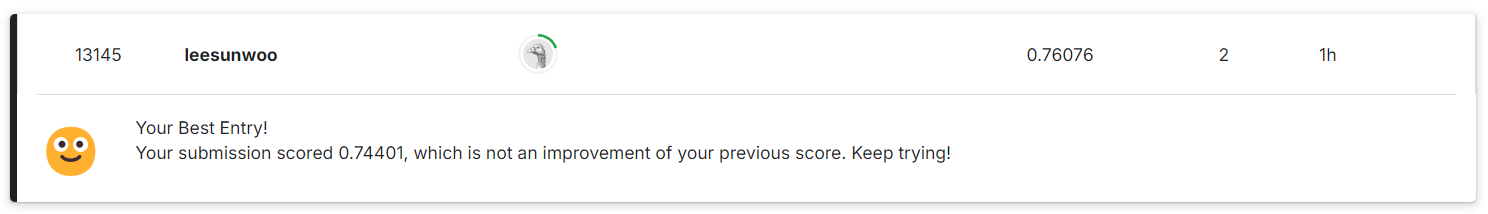

## **숙제후기**

이번 과제를 수행하면서 수집된 데이터가 어떠한 방식으로 전처리 되고 모델에 학습되고 예측을 수행하는지 그 흐름을 알게되었다. 최적의 지점에서 중단하고 csv 파일을 생성하기 위해 early stoping을 이용했는데 너무 초반에 멈춰서 그런지 처음 캐글에 해당 모델에서 예측된 csv 파일을 업로드했을땐 0.67xxx 정도의 점수가 나왔다. 좀 길게 가져가기 위해 100단위로 끊고 거기서 또 10회 또는 20회 검증 손실이 개선되지 않아야 멈추는것으로 변경했더니 0.76xxx까진 올랐다. 또한 수행하면서 좀 편차가 크게 나왔는데 이게 정상적인건지는 의문이다. 코드를 건든 부분은 좀 적지만 그래도 어떠한 데이터를 가지고 모델을 학습시키고 예측을 수행하며 교재, 코드로만 보는것보다 더 깊게 알게된것같다.